### Credit Card Write Off

In [1]:
# Load libraries
import pandas as pd
import sklearn_pandas
import numpy as np
from xgboost import XGBClassifier  
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import os # used to create necessary folders
import json
import sys
import pickle
import zipfile
from math import sqrt
from scipy.stats import kendalltau
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix                    
from sklearn.metrics import fbeta_score
from scipy.stats import ks_2samp

In [2]:
credit = pd.read_csv('CREDITWRITEOFF.csv',sep= ',')

In [3]:
credit

,acctcd_n,age,atmuser,behave_scr,CARD_TYPE,CREDIT_LIM,currbal,delnum,ecomuser,CREDIT_SCORE,...,SSN,t_asset,T_debt,T_debtserv,T_liab,writeoff,YEAR,ZIPCODE,account_id,_PartInd_
0,1,43,N,380,VISA,6000.0,3500.0,4,Y,615,...,37625,1500.0,15200.0,608.0,16700.0,1,2013,92108,7891694488,1
1,1,30,N,500,VISA,3000.0,625.0,4,N,675,...,45699,15000.0,136500.0,9555.0,151500.0,1,2013,97211,1816266143,1
2,1,35,N,300,VISA,7000.0,5000.0,4,N,501,...,102749,200000.0,0.0,0.0,8500.0,1,2013,90020,7747955424,1
3,1,45,N,420,VISA,6000.0,3500.0,0,N,708,...,110692,300000.0,0.0,0.0,201500.0,0,2012,95114,4065329048,1
4,1,36,Y,380,MC,3000.0,575.0,4,N,550,...,112833,7500.0,9200.0,368.0,16700.0,1,2013,94116,7511954190,0
5,1,59,N,420,VISA,3000.0,750.0,1,N,561,...,120302,20000.0,0.0,0.0,8500.0,0,2013,92108,404401045,1
6,1,31,N,260,VISA,9000.0,6920.0,0,N,651,...,139666,1500.0,300000.0,15000.0,301500.0,0,2012,85032,6353977824,0
7,3,39,N,460,MC,5000.0,3450.0,2,N,726,...,149610,250000.0,51500.0,2575.0,301500.0,0,2012,84605,2188437461,1
8,1,34,Y,220,VISA,6000.0,4475.0,0,N,621,...,153338,15000.0,236500.0,11825.0,251500.0,0,2012,85032,1572583584,0
9,1,45,N,380,MC,6000.0,3500.0,4,Y,579,...,165907,20000.0,0.0,0.0,16700.0,1,2012,92110,4556638400,1


In [4]:
target = credit['writeoff']

In [5]:
credit["atmuser"] = credit["atmuser"].eq('Y').mul(1).values
credit["CARD_TYPE"] = credit["CARD_TYPE"].eq('VISA').mul(1).values
credit["ecomuser"] = credit["ecomuser"].eq('Y').mul(1).values
credit["GENDER"] = credit["GENDER"].eq('M').mul(1).values
credit["okmail"] = credit["okmail"].eq('Y').mul(1).values
credit.drop("OPEN_DT",axis=1,inplace=True)
credit.drop("_PartInd_",axis=1,inplace=True)
credit.drop("SSN",axis=1,inplace=True)
credit.drop("delnum",axis=1,inplace=True)

In [6]:
credit.head()

,acctcd_n,age,atmuser,behave_scr,CARD_TYPE,CREDIT_LIM,currbal,ecomuser,CREDIT_SCORE,GENDER,...,ROC3,ROC6,t_asset,T_debt,T_debtserv,T_liab,writeoff,YEAR,ZIPCODE,account_id
0,1,43,0,380,1,6000.0,3500.0,1,615,1,...,11,23,1500.0,15200.0,608.0,16700.0,1,2013,92108,7891694488
1,1,30,0,500,1,3000.0,625.0,0,675,1,...,0,10,15000.0,136500.0,9555.0,151500.0,1,2013,97211,1816266143
2,1,35,0,300,1,7000.0,5000.0,0,501,0,...,13,32,200000.0,0.0,0.0,8500.0,1,2013,90020,7747955424
3,1,45,0,420,1,6000.0,3500.0,0,708,0,...,11,23,300000.0,0.0,0.0,201500.0,0,2012,95114,4065329048
4,1,36,1,380,0,3000.0,575.0,0,550,0,...,17,29,7500.0,9200.0,368.0,16700.0,1,2013,94116,7511954190


In [7]:
# Specify the categorical target variable
y = target.astype('category')

# Retrieve the categories of the target variable
y_category = y.cat.categories
nYCat = len(y_category)
print(y_category)

Int64Index([0, 1], dtype='int64')


In [8]:
credit.columns

Index(['acctcd_n', 'age', 'atmuser', 'behave_scr', 'CARD_TYPE', 'CREDIT_LIM',
       'currbal', 'ecomuser', 'CREDIT_SCORE', 'GENDER', 'hhincome', 'okmail',
       'p_bankrupt', 'p_churn', 'p_revenue', 'p_risk', 'prodnum', 'ROC1',
       'ROC12', 'ROC3', 'ROC6', 't_asset', 'T_debt', 'T_debtserv', 'T_liab',
       'writeoff', 'YEAR', 'ZIPCODE', 'account_id'],
      dtype='object')

In [9]:
#split dataset in features and target variable
predictors = ['acctcd_n', 'age', 'atmuser', 'behave_scr', 'CARD_TYPE', 'CREDIT_LIM','currbal', 'ecomuser', 'CREDIT_SCORE', 'GENDER', 'hhincome',
       'okmail', 'p_bankrupt', 'p_churn', 'p_revenue', 'p_risk', 'prodnum','ROC1', 'ROC12', 'ROC3', 'ROC6', 't_asset', 'T_debt',
       'T_debtserv', 'T_liab', 'YEAR', 'ZIPCODE', 'account_id']
X = credit[predictors] # Features
y = credit.writeoff # Target variable

In [10]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

# Threshold for the misclassification error (BAD: 0-No, 1-Yes)
threshPredProb = np.mean(y_test.values)
print(threshPredProb)


0.4096666666666667


In [11]:
X_test.fillna(X_test.mean(), inplace=True)
X_train.fillna(X_train.mean(), inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [12]:
# Create Decision Tree classifer object
clf = XGBClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [13]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.596


## Score Code

This box should be save inside a zip file as .py file ex: 'fleet_DT_score.py'. It will be used to generate a ds2 code for fleet_DT model

change _pfile to the location where your pickle will be located in a server

In [14]:
import numpy
import pandas
import pickle

#inside input parameter goes all the predictor/input variables
def scoreFleetDTModel (acctcd_n, age, atmuser, behave_scr, CARD_TYPE, CREDIT_LIM,currbal,ecomuser,CREDIT_SCORE,GENDER,hhincome, okmail, p_bankrupt, p_churn, p_revenue, p_risk, prodnum,ROC1, ROC12, ROC3, ROC6, t_asset, T_debt,T_debtserv, T_liab, YEAR, ZIPCODE, account_id):
    "Output: EM_EVENTPROBABILITY, EM_CLASSIFICATION"

    try:
        _thisModelFit
    except NameError:
        # once you create a project, use the uuid create a unique folder associated to the project and place .pickle
        # replace 'model-specific-uuid' with the uuid folder name inside _pFile
        _pFile = open("/opt/sas/viya/config/data/modelsvr/resources/model-specific-uuid/credit_XGB.pickle", "rb")
        _thisModelFit = pickle.load(_pFile)
        _pFile.close()

    
    # Construct the input array for scoring (the first term is for the Intercept)
    # mapyour input parameters with associated column names in pandas table
    input_array = pandas.DataFrame([[acctcd_n, age, atmuser, behave_scr, CARD_TYPE, CREDIT_LIM,currbal, ecomuser,CREDIT_SCORE,GENDER,hhincome, okmail, p_bankrupt, p_churn, p_revenue, p_risk, prodnum,ROC1, ROC12, ROC3, ROC6, t_asset, T_debt,T_debtserv, T_liab, YEAR, ZIPCODE, account_id]],
                                   
                                   columns = ['acctcd_n', 'age', 'atmuser', 'behave_scr', 'CARD_TYPE', 'CREDIT_LIM',
       'currbal', 'ecomuser', 'CREDIT_SCORE', 'GENDER', 'hhincome',
       'okmail', 'p_bankrupt', 'p_churn', 'p_revenue', 'p_risk', 'prodnum',
       'ROC1', 'ROC12', 'ROC3', 'ROC6', 't_asset', 'T_debt', 'T_debtserv',
       'T_liab', 'YEAR', 'ZIPCODE', 'account_id'], 
                                   dtype = float)
    
    # perform the same preprocessing procedure as it was done during training
    input_array.fillna(input_array.mean(), inplace=True)

    
    # Calculate the predicted probabilities
    _predProb = _thisModelFit.predict(input_array)

    # Retrieve the event probability
    EM_EVENTPROBABILITY = float(_predProb[1])

    # Determine the predicted target category
    EM_CLASSIFICATION = _predProb.idxmax(axis = 1).to_string(index=False)

    return(EM_EVENTPROBABILITY, EM_CLASSIFICATION)

# Creating Assessment Metric, Save in JSON, Zip the Model

## 1. Assessment metrics

In [15]:
#Assess the model before generating assessment metrics
y_predProb = clf.predict_proba(X_test).astype(np.float64)

### Average Squared Error

In [16]:
y_sqerr = np.where(y_test == 1, (1.0 - y_predProb[:,1])**2, (0.0 - y_predProb[:,1])**2)
y_ase = np.mean(y_sqerr)
y_rase = np.sqrt(y_ase) 
print("Root Average Square Error = ", y_rase)


Root Average Square Error =  0.4877284569364847


### Misclassification Error

In [17]:
y_predict = np.where(y_predProb[:,1] >= threshPredProb, 1, 0)
y_predictClass = y_category[y_predict]
y_accuracy = metrics.accuracy_score(y_test, y_predictClass)
print("Accuracy Score = ", y_accuracy)
print("Misclassification Error =", 1.0 - y_accuracy)

Accuracy Score =  0.5726666666666667
Misclassification Error = 0.42733333333333334


### Area Under Curve

Area Under Curve =  0.5794830280272669


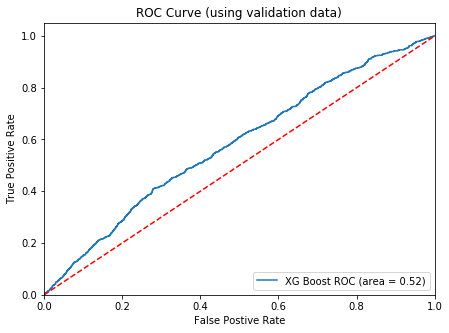

In [18]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
%matplotlib inline

# Area Under Curve
y_roc = metrics.roc_auc_score(y_test.values, y_predProb[:,1]) 
print("Area Under Curve = ", y_roc)

# # Generate the coordinates for the ROC curve
# OneMinusSpecificity, Sensitivity, thresholds = metrics.roc_curve(y_test, y_predProb[:,1], pos_label = 1)

# # Add two dummy coordinates
# OneMinusSpecificity = np.append([0], OneMinusSpecificity)
# Sensitivity = np.append([0], Sensitivity)

# OneMinusSpecificity = np.append(OneMinusSpecificity, [1])
# Sensitivity = np.append(Sensitivity, [1])

models = [{'label': 'XG Boost','model': clf}]

# Draw ROC
plt.figure(figsize = (7, 5))
for m in models:
    clf = m['model']
    fpr, tpr, thresholds = metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    auc = metrics.roc_auc_score(y_test,clf.predict(X_test))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (using validation data)')
plt.legend(loc="lower right")
plt.show()

### Create FitStats

In [19]:
# Put the fit statistics into the fitStats series, names in index
fitStats = pd.Series(['TEST',
                          1,
                          '           1',
                         len(y),
                         y_ase,
                         len(y),
                         y_rase,
                         (1.0 - y_accuracy),
                         threshPredProb,
                         y_roc],
                         index = ['_DataRole_',
                                  '_PartInd_',
                                  '_PartInd__f',
                                  '_NObs_', 
                                  '_ASE_',
                                  '_DIV_',
                                  '_RASE_',
                                  '_MCE_',
                                  '_THRESH_',
                                  '_C_'])
print(fitStats)

_DataRole_             TEST
_PartInd_                 1
_PartInd__f               1
_NObs_                10000
_ASE_              0.237879
_DIV_                 10000
_RASE_             0.487728
_MCE_              0.427333
_THRESH_           0.409667
_C_                0.579483
dtype: object


In [20]:
# Prepare the materials for importing the model to the Model Manager
# Create a benchmark data for checking accuracy of score
outputVar = pd.DataFrame(columns = ['EM_EVENTPROBABILITY', 'EM_CLASSIFICATION'])
outputVar['EM_CLASSIFICATION'] = y_category.astype('str')
outputVar['EM_EVENTPROBABILITY'] = 0.5
print(outputVar)

# outputScore = pd.DataFrame(index = X_test.index)
# outputScore['P_BAD0'] = y_predProb[:,0]
# outputScore['P_BAD1'] = y_predProb[:,1]
# outputScore['I_BAD'] = y_predictClass

# test_wscore = pd.DataFrame.merge(X_test, outputScore, how = 'left', left_index = True, right_index = True)
# test_wscore.head()

# with pandas.ExcelWriter(analysisFolder + 'hmeq_xgboost_score.xlsx') as writer:
#     train_wscore.to_excel(writer, sheet_name = 'With Score')


   EM_EVENTPROBABILITY EM_CLASSIFICATION
0                  0.5                 0
1                  0.5                 1


## 2. Save Files in JSON Format

### JSON transfer instructions

In [21]:
# Instructions for how to save different JSON files
def WriteVarJSON (inputDF, debug = 'N'):
    inputName = inputDF.columns.values.tolist()
    outJSON = pandas.DataFrame() 

    for pred in inputName:
        thisVar = inputDF[pred]
        firstRow = thisVar.loc[thisVar.first_valid_index()]
        dType = thisVar.dtypes.name
        dKind = thisVar.dtypes.kind
#         isNum = pandas.api.types.is_numeric_dtype(firstRow)
        try:
            isNum = pandas.api.types.is_numeric_dtype(firstRow)
        except:
            isNum = False
        isStr = pandas.api.types.is_string_dtype(thisVar)

        if (debug == 'Y'):
            print('pred =', pred)
            print('dType = ', dType)
            print('dKind = ', dKind)
            print('isNum = ', isNum)
            print('isStr = ', isStr)

        if (isNum):
            if (dType == 'category'):
                outLevel = 'nominal'
            else:
                outLevel = 'interval'
            outType = 'decimal'
            outLen = 8
        elif (isStr):
            outLevel = 'nominal'
            outType = 'string'
            outLen = thisVar.str.len().max()

        outRow = pandas.Series([pred, outLen, outType, outLevel],
                               index = ['name', 'length', 'type', 'level'])
                           
        outJSON = outJSON.append([outRow], ignore_index = True)

    return (outJSON)

def WriteClassModelPropertiesJSON (modelName, modelDesc, targetVariable, modelType, modelTerm, targetEvent, nTargetCat, eventProbVar = None):

    thisForm = modelDesc + ' : ' + targetVariable + ' = '
    iTerm = 0
    for thisTerm in modelTerm:
        if (iTerm > 0):
            thisForm = thisForm + ' + '
        thisForm += thisTerm
        iTerm += 1

    if (nTargetCat > 2):
        targetLevel = 'NOMINAL'
    else:
        targetLevel = 'BINARY'

    if (eventProbVar == None):
        eventProbVar = 'P_' + targetVariable + targetEvent

    modeler = 'happymodeler'

    toolVersion = str(sys.version_info.major) + '.' + str(sys.version_info.minor) + '.' + str(sys.version_info.micro)

    thisIndex = ['name', 'description', 'function', 'scoreCodeType', 'trainTable', 'trainCodeType', 'algorithm', \
                 'targetVariable', 'targetEvent', 'targetLevel', 'eventProbVar', 'modeler', 'tool', 'toolVersion']

    thisValue = [modelName, \
                 thisForm, \
                 'classification', \
                 'python', \
                 ' ', \
                 'Python', \
                 modelType, \
                 targetVariable, \
                 targetEvent, \
                 targetLevel, \
                 eventProbVar, \
                 modeler, \
                 'Python 3', \
                 toolVersion]

    outJSON = pandas.Series(thisValue, index = thisIndex)

    return(outJSON)


def prep_rocstat(model, X_train, y_train, X_test, y_test, targetname, outdir, templatedir):

    '''
    Function to prepare ROC json file
    '''
    
    #print("Printing...")
    
    # Define CustomThreshold class
    class CustomThreshold(BaseEstimator, ClassifierMixin):
        """ Custom threshold wrapper for binary classification"""
    
        def __init__(self, base, threshold=0.5):
            self.base = base
            self.threshold = threshold

        def fit(self, *args, **kwargs):
            self.base.fit(*args, **kwargs)
            return self

        def predict(self, X):
            return (self.base.predict_proba(X)[:, 1] >= self.threshold).astype(int)
   

    # Prepare sample
    X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.3, random_state=12345)

    # Load template
    with open(templatedir + "/dmcas_roc_template_class.json", "r") as jsonFile:
        body = json.load(jsonFile)

    # Create measures lists
    th=range(0, 105, 5)
    th_final=[]
    count_th=0 

    for i in th:
        th_final.append(round(i/100,2))

    count_row=0
    part_list=(2,1,0)

    for j in part_list:

        clf = [CustomThreshold(model, threshold) for threshold in list(th_final)]

        row=0

        for _ in range(0, 110, 5): 

            stats = dict()

            # define datasets
            if j==1:   # train
                X_part=X_t
                y_part=y_t
                stats.update(_DataRole_='TRAIN')
                stats.update(_PartInd_= "1")
                stats.update(_PartInd__f = "           1")

            elif j==0:  # validation
                X_part=X_v
                y_part=y_v
                stats.update(_DataRole_='VALIDATE')
                stats.update(_PartInd_= "0")
                stats.update(_PartInd__f= "           0")

            elif j==2:  # test
                X_part=X_test
                y_part=y_test
                stats.update(_DataRole_='TEST')
                stats.update(_PartInd_= "2")
                stats.update(_PartInd__f = "           2")

            if (row+1) == 22:
                stats.update(_ACC_ = None)
                stats.update(_TP_ = None)
                stats.update(_OneMinusSpecificity_ = "0")
                stats.update(_Column_ = 'P_' +str(targetname) +'1')           
                stats.update(_TN_ = None)
                stats.update(_KS2_ = None)
                stats.update(_FPR_ = "0")                          
                stats.update(_FDR_ = "0")
                stats.update(_MiscEvent_ = None)       
                stats.update(_FN_ = None)
                stats.update(_KS_ = None)                       
                stats.update(_Sensitivity_ = "0")
                stats.update(_Event_ = "1")
                stats.update(_FP_ = None)          
                stats.update(_Cutoff_ = "1")
                stats.update(_Specificity_ = "1")
                stats.update(_FHALF_ = None)    

            else:
                # score model for each threshold
                y_score=clf[row].predict(X_part)

                stats.update(_Cutoff_= str(th_final[row]))

                # confusion matrix
                tn, fp, fn, tp = confusion_matrix(y_part, y_score).ravel()
                stats.update(_TP_= str(tp))
                stats.update(_TN_ = str(tn))
                stats.update(_FN_ = str(fn))
                stats.update(_FP_ = str(fp))  

                # sensitivity, hit rate, recall, or true positive rate
                tpr = tp/(tp+fn)
                stats.update(_Sensitivity_= str(tpr))

                # specificity or true negative rate
                tnr = tn/(tn+fp)

                # precision or positive predictive value
                #ppv = tp/(tp+fp)

                # negative predictive value
                #npv = tn/(tn+fn)

                # fall out or false positive rate
                fpr = fp/(fp+tn)
                stats.update(_OneMinusSpecificity_ = str(fpr))
                stats.update(_FPR_ = str(fpr))
                stats.update(_Specificity_ = str(fpr + 1))

                # false negative rate
                fnr = fn/(tp+fn)

                # false discovery rate
                fdr = fp/(tp+fp)
                stats.update(_FDR_ = str(fdr))

                # overall accuracy
                acc = (tp+tn)/(tp+fp+fn+tn)
                stats.update(_ACC_=str(acc))
                stats.update(_MiscEvent_ = str(1-acc))

                # F0.5 score
                f_05 = fbeta_score(y_part, y_score, beta=0.5)
                stats.update(_FHALF_ = str(f_05))

                # KS statistics on 2 samples
                y_score_arr = np.array(y_score)
                y_score_df = pd.DataFrame(data=y_score_arr)
                y_test_arr = np.array(y_part)
                y_test_df = pd.DataFrame(data=y_test_arr)
                KS_2 = ks_2samp(y_test_df[0], y_score_df[0])
                stats.update(_KS2_= str(KS_2[0]))

                # misc
                stats.update(_Column_= 'P_' +str(targetname) +'1')
                stats.update(_KS_= str(max(tpr-fpr,0)))      # to check
                stats.update(_Event_= "1")

            body['data'][count_row] = {'dataMap': stats}
            body['data'][count_row]['rowNumber']=str(count_row+1)
            body['data'][count_row]['header']=None
            
            row += 1
            count_row += 1             


    with open(outdir + '/dmcas_roc.json', 'w') as f:
        json.dump(body, f, indent=2)

    print("Saved in:", outdir)



def prep_liftstat(model, X_train, y_train, X_test, y_test, targetname, targetvalue, outdir, templatedir):

    '''
    Function to prepare Liftstat json file
    https://go.documentation.sas.com/?cdcId=vdmmlcdc&cdcVersion=1.0&docsetId=casml&docsetTarget=viyaml_assess_examples01.htm&locale=en
    '''

    # prepare sample

    X_t, X_v, y_t, y_v = train_test_split(
        X_train, y_train, test_size=0.3, random_state=12345)
    data = [(X_t, y_t, model.predict_proba(X_t)),
            (X_v, y_v, model.predict_proba(X_v)),
            (X_test, y_test, model.predict_proba(X_test))]

    # prepare function

    def calc_cumulative_gains(df: pd.DataFrame, actual_col: str, predicted_col: str, probability_col: str):

        df.sort_values(by=probability_col, ascending=False, inplace=True)

        subset = df[df[predicted_col] == True]

        rows = []

        for group in np.array_split(subset, 20):
            score = metrics.accuracy_score(group[actual_col].tolist(),
                                           group[predicted_col].tolist(),
                                           normalize=False)

            rows.append({'NumCases': len(group),
                         'NumCorrectPredictions': score})

        lift = pd.DataFrame(rows)

        # Cumulative Gains Calculation

        lift['RunningCorrect'] = lift['NumCorrectPredictions'].cumsum()
        lift['PercentCorrect'] = lift.apply(
            lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x['RunningCorrect'], axis=1)
        lift['CumulativeCorrectBestCase'] = lift['NumCases'].cumsum()
        lift['PercentCorrectBestCase'] = lift['CumulativeCorrectBestCase'].apply(
            lambda x: 100 if (100 / lift['NumCorrectPredictions'].sum()) * x > 100 else (100 / lift[
                'NumCorrectPredictions'].sum()) * x)
        lift['AvgCase'] = lift['NumCorrectPredictions'].sum() / len(lift)
        lift['CumulativeAvgCase'] = lift['AvgCase'].cumsum()
        lift['PercentAvgCase'] = lift['CumulativeAvgCase'].apply(
            lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x)

        # Lift Chart
        lift['NormalisedPercentAvg'] = 1
        lift['NormalisedPercentWithModel'] = lift['PercentCorrect'] / \
            lift['PercentAvgCase']

        lift_dict = lift.to_dict()

        return lift_dict


    with open(templatedir + '/R_HMEQ_lift.json', 'r') as i:

        body = json.load(i)

    count = 0

    for j in range(3):

        # prepare data

        data[j][0].reset_index(drop=True, inplace=True)
        data[j][1].reset_index(drop=True, inplace=True)
        score_probability = pd.DataFrame(data[j][2], columns=[
                                         'P_' + str(targetname) + '0', 'P_' + str(targetname) + '1'])
        df = pd.concat([data[j][0], data[j][1], score_probability], axis=1)
        df['pred_col'] = np.where(
            df['P_' + str(targetname) + '1'] >= 0.5, 1, 0)

        df.sort_values(by='P_' + str(targetname) + '1',
                       ascending=False, inplace=True)

        subset = df[df['pred_col'] == True]

        rows = []

        for group in np.array_split(subset, 20):

            score = metrics.accuracy_score(
                group[targetname].tolist(), group['pred_col'].tolist(), normalize=False)

            rows.append({'NumCases': len(group),
                         'NumCorrectPredictions': score})

            lift = pd.DataFrame(rows)

            # Cumulative Gains Calculation

            lift['RunningCorrect'] = lift['NumCorrectPredictions'].cumsum()
            lift['PercentCorrect'] = lift.apply(
                lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x['RunningCorrect'], axis=1)
            lift['CumulativeCorrectBestCase'] = lift['NumCases'].cumsum()
            lift['PercentCorrectBestCase'] = lift['CumulativeCorrectBestCase'].apply(
                lambda x: 100 if (100 / lift['NumCorrectPredictions'].sum()) * x > 100 else (100 / lift[
                    'NumCorrectPredictions'].sum()) * x)
            lift['AvgCase'] = lift['NumCorrectPredictions'].sum() / len(lift)
            lift['CumulativeAvgCase'] = lift['AvgCase'].cumsum()
            lift['PercentAvgCase'] = lift['CumulativeAvgCase'].apply(
                lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x)

            # Lift Chart
            lift['NormalisedPercentAvg'] = 1
            lift['NormalisedPercentWithModel'] = lift['PercentCorrect'] / \
                lift['PercentAvgCase']
            lift['Gain'] = lift['NormalisedPercentWithModel'] - lift['NormalisedPercentAvg']

            lift_dict = lift.to_dict()

#             return lift_dict


#         calc_cumulative_gains(perf_probability, targetname, 'pred_col', 'P_' + str(targetname) + '1')

        for index, row in enumerate(range(0, 105, 5)):
        
            count=count+1
        
            stats = dict()

            if j == 0:
                stats.update(_DataRole_='VALIDATE')
            if j == 1:
                stats.update(_DataRole_='TRAIN')
            if j == 2:
                stats.update(_DataRole_='TEST')

            if index == 0:

                stats.update(_CumLiftBest_=None)
                stats.update(_NObs_='0')
                stats.update(_Depth_='0')
                stats.update(_CumRespBest_='0')
                stats.update(_formattedPartition_='           0')
                stats.update(_Column_=str(targetname))
                stats.update(_Lift_=None)
                stats.update(_RespBest_='0')
                stats.update(_CumPctResp_=None)
                stats.update(_NEventsBest_='0')
                stats.update(_CumResp_='0')
                stats.update(_PctRespBest_=None)
                stats.update(_Gain_=None)
                stats.update(_CumLift_='0')
                stats.update(_CumPctRespBest_=None)
                stats.update(_Value_='0')
                stats.update(_Event_=str(targetvalue))
                stats.update(_NEvents_='0')
                stats.update(_PctResp_=None)
                stats.update(_LiftBest_=None)
                stats.update(_PartInd_='0')
                stats.update(_Resp_='0')
                stats.update(_GainBest_=None)
            
            else:
                stats.update(_CumLiftBest_=str(lift_dict['NormalisedPercentWithModel'][index-1]))
                stats.update(_NObs_=str(lift_dict['NumCases'][index-1]))
                stats.update(_Depth_=str(index-1))
                stats.update(_CumRespBest_='100')
                stats.update(_formattedPartition_='           0')
                stats.update(_Column_=str(targetname))
                stats.update(_Lift_=str(lift_dict['NormalisedPercentWithModel'][index-1]))
                stats.update(_RespBest_=str(lift_dict['PercentCorrect'][index-1]))
                stats.update(_CumPctResp_=str(lift_dict['PercentCorrectBestCase'][index-1]))
                stats.update(_NEventsBest_=str(lift_dict['NumCorrectPredictions'][index-1]))
                stats.update(_CumResp_=str(lift_dict['RunningCorrect'][index-1]))
                stats.update(_PctRespBest_=str(lift_dict['PercentCorrect'][index-1]))
                stats.update(_Gain_=str(lift['Gain'][index-1]))
                stats.update(_CumLift_=str(lift_dict['RunningCorrect'][index-1]))
                stats.update(_CumPctRespBest_=str(lift_dict['PercentCorrect'][index-1]))
                stats.update(_Value_=str(lift['Gain'][index-1]))
                stats.update(_Event_=str(targetvalue))
                stats.update(_NEvents_=str(' '))
                stats.update(_PctResp_=str(lift_dict['PercentCorrect'][index-1]))
                stats.update(_LiftBest_=str(lift_dict['NormalisedPercentWithModel'][index-1]))
                stats.update(_PartInd_=str(j))
                stats.update(_Resp_=str(lift_dict['PercentCorrect'][index-1]))
                stats.update(_GainBest_=str(lift['Gain'][index-1]))

            body['data'][count-1] = {'dataMap': stats}
            body['data'][count-1]['rowNumber']=count
            body['data'][count-1]['header']=None

    with open(outdir + '/dmcas_lift.json', 'w') as f:
        json.dump(body, f, indent=2)

    print("Saved in:", outdir)



def prep_fitstat(model, X_train, y_train, X_test, y_test, outdir, templatedir):
    '''
    Function to prepare FitStat json file
    '''
    # prepare sample
    X_t, X_v, y_t, y_v=train_test_split(X_train,y_train,test_size=0.3, random_state=12345)
    data=[(y_t,model.predict(X_t)),(y_v,model.predict(X_v)),(y_test,model.predict(X_test))]
    
    #Open template get from SAS VDMML model register into MM
    
    with open(templatedir + '/R_HMEQ_fitstat.json', 'r') as f:
        body=json.load(f)
        
    for i in range(3):
        
        stats=dict()
        
        # RASE uses the root average squared error as the objective function
        stats.update(_RASE_=str(sqrt(metrics.mean_squared_error(data[i][0], data[i][1]))))

        # Number of sample observation
        stats.update(_NObs_=str(len(data[i][0])))

        # AUC uses area under the curve as the objective function
        fpr, tpr, thresholds = metrics.roc_curve(data[i][0],data[i][1])
        auc = metrics.roc_auc_score(data[i][0],data[i][1])

        # GINI uses the Gini coefficient as the objective function
        stats.update(_GINI_= str((2 * auc) - 1))

        # GAMMA uses the gamma coefficient as the objective function
        # from scipy.stats import gamma
        # shape, loc, scale = gamma.fit(model.predict(updata), floc=0)
        # _GAMMA_ = 1/scale

        # GAMMA (Method of Moments) uses the gamma coefficient as the objective function

        def calculateGammaParams(data):
            mean = np.mean(data)
            std = np.std(data)
            shape = (mean/std)**2
            scale = (std**2)/mean
            return (shape, 0, scale)

        eshape, eloc, escale = calculateGammaParams(data[i][1])

        stats.update(_GAMMA_ = str(1/escale))

        # _formattedPartition_
        
        if i==0:
            stats.update(_DataRole_='TRAIN')
        if i==1:
            stats.update(_DataRole_='TEST')
        if i==2:
            stats.update(_DataRole_='VALIDATE')
        
        # _DataRole_
            
        stats.update(_formattedPartition_='           '+str(i))

        # MCE uses the misclassification rate as the objective function

        stats.update(_MCE_ = str(1-metrics.accuracy_score(data[i][0], data[i][1])))

        # ASE uses average squared error as the objective function
        stats.update(_ASE_ = str(metrics.mean_squared_error(data[i][0], data[i][1])))

        # MCLL uses the multiclass log loss as the objective function
        stats.update(_MCLL_ = str(metrics.log_loss(data[i][0], data[i][1])))

        # KS uses the Kolmogorov-Smirnov coefficient as the objective function
        stats.update(_KS_=str(max(fpr-tpr)))

        # _KSPostCutoff_
        
        stats.update(_KSPostCutoff_='null')
        
        #_DIV_

        stats.update(_DIV_ = len(data[i][0]))

        # TAU uses the tau coefficient as the objective function

        stats.update(_TAU_ = str(kendalltau(data[i][0], data[i][1])[0]))

        # C uses Area Under ROC

        stats.update(_C_ = str(metrics.auc(fpr, tpr)))

        # _KSCut_
        
        stats.update(_KSCut_ = 'null')

        _PartInd_ = str(i)
        
        # rowNumber
        
        stats.update(rowNumber = str(i))
        
        # header 
        
        stats.update(header = 'null')
        
        body['data'][i]={'dataMap':stats}
    
    with open(outdir + '/dmcas_fitstat.json', 'w') as f:
        json.dump(body, f,indent=2)

    print("Saved in:", outdir)


### Transfer Data to Json

In [22]:
# Define the analysis folder
analysisFolder = str('./MM/Test/Credit_WO/XGB/')

if not(os.path.exists(analysisFolder)):
    os.makedirs(analysisFolder)
    print("Directory " , analysisFolder ,  " created")
else:
    print("Directory " , analysisFolder,  " already exists")


# name of the target variable
yName = "writeoff"

# Define the prefix for model specific file name
prefixModelFile = "credit_XGB"

# Create the fileMetadata.json file
fileMetadataJSON = pandas.DataFrame([['inputVariables', 'inputVar.json'],
                                     ['outputVariables', 'outputVar.json'],
                                     ['score', prefixModelFile + '_score.py'],
                                     ['python pickle', prefixModelFile + '.pickle']],
                                    columns = ['role', 'name'])

#Create the JSON files that will be zipped into a ZIP file

# Write inputVar.json
inputVarJSON = WriteVarJSON(X_test, debug = 'N')
jFile = open(analysisFolder + 'inputVar.json', 'w')
json.dump(list(pandas.DataFrame.to_dict(inputVarJSON.transpose()).values()), jFile, indent = 4, skipkeys = True)
jFile.close()

# Write outputVar.json
outputVarJSON = WriteVarJSON(outputVar, debug = 'N')
jFile = open(analysisFolder + 'outputVar.json', 'w')
json.dump(list(pandas.DataFrame.to_dict(outputVarJSON.transpose()).values()), jFile, indent = 4, skipkeys = True)
jFile.close()

# Write fileMetadata.json
jFile = open(analysisFolder + 'fileMetadata.json', 'w')
json.dump(list(pandas.DataFrame.to_dict(fileMetadataJSON.transpose()).values()), jFile, indent = 4, skipkeys = True)
jFile.close()

# Write ModelProperties.json
# put your custom information
modelPropertyJSON = WriteClassModelPropertiesJSON ('Fleet', 'XGBoost Model',
                                                   yName, 'XGBoost Tree', X_test.columns.values,
                                                   y_category[1].astype('str'), nYCat, 'EM_EVENTPROBABILITY')
jFile = open(analysisFolder + 'ModelProperties.json', 'w')
json.dump(pandas.Series.to_dict(modelPropertyJSON), jFile, indent = 4, skipkeys = True)
jFile.close()

# templates are json file templates that will be used to populate fitstat, roc and lift values of the model
templatedir = "./templates"
# fit stat
prep_fitstat(clf,X_train,y_train,X_test,y_test, analysisFolder, templatedir)
# lift stat
prep_liftstat(clf,X_train,y_train,X_test,y_test, yName, '1', analysisFolder, templatedir)
# roc stat
prep_rocstat(clf,X_train,y_train,X_test,y_test, yName, analysisFolder, templatedir)

Directory  ./MM/Test/Credit_WO/XGB/  already exists
Saved in: ./MM/Test/Credit_WO/XGB/
Saved in: ./MM/Test/Credit_WO/XGB/


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:218: RuntimeWarning: invalid value encountered in long_scalars
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Saved in: ./MM/Test/Credit_WO/XGB/


## Zip Files

In [24]:
# Open a writable binary file for saving the pickle object
pFile = open(analysisFolder + prefixModelFile + '.pickle', 'wb')
pickle.dump(clf, pFile)
pFile.close() 

# Create the zip file package (without the full path name)
zFile = zipfile.ZipFile(analysisFolder + prefixModelFile + '.zip', mode = 'w')
zFile.write(analysisFolder + 'inputVar.json', 'inputVar.json')
zFile.write(analysisFolder + 'outputVar.json', 'outputVar.json')
zFile.write(analysisFolder + 'ModelProperties.json', 'ModelProperties.json')
zFile.write(analysisFolder + 'fileMetadata.json', 'fileMetadata.json')
zFile.write(analysisFolder + 'dmcas_fitstat.json', 'dmcas_fitstat.json')
zFile.write(analysisFolder + 'dmcas_lift.json', 'dmcas_lift.json')
zFile.write(analysisFolder + 'dmcas_roc.json', 'dmcas_roc.json')
zFile.write(analysisFolder + prefixModelFile + '_score.py', prefixModelFile + '_score.py')
zFile.write(analysisFolder + prefixModelFile + '.pickle', prefixModelFile + '.pickle')
zFile.close()